O3 농도 예측 모델의 학습 및 모델 예측 테스트 코드

VER: 
    
    v2.3

SETUP:

    In[NOx, SOX, VOC, NH3, PM2.5]
    Out[pred. O3]

STRUCTURE:

    CMAQ U-Net (w/o Conditional)

    model = build_model(
        ..., 
        ~~emb_dims=[64],~~
        ...,
        hidden_size=[128, 96],
        ...,
        in_filters=10,
        ...
    )

PARAMETER:

    EPOCH = 1000
    Lr = 1e-3
    test_split = 0.4

In [6]:
# Import
import os
import sys
sys.path.append('/home/user/workdir/CMAQ_Emulator/main')

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

# Training

In [7]:
dataset_2013 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2013.csv')
# dataset_2013['Boundary'] = 1.0

ctrl_data = pd.concat([dataset_2013], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data = ctrl_data[:, :17*5]
# -------------
label_path_2013 = '/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2013'

label_path = []
for i in range(1, 120): 
    label_path.append(os.path.join(label_path_2013, '1.00', f'ACONC.{i}'))

label_data = []
for path in label_path:
    with nc.Dataset(path) as f:
        label_data.append(f.variables['O3'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
label_data = np.array(label_data).reshape(len(label_data), 82, 67, 1)

In [8]:
from src.model.cmaqnet_unet import build_model

model_path = '/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model'  # 모델 저장 경로

epochs = 1000  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (50%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, y_train, y_test = train_test_split(emis_data, label_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*5,
        out_channel=1,
        hidden_size=[128, 96],
        hidden_depth=4,
        in_filters=10,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanAbsoluteError(),
    )
    
# define callback
def scheduler(epoch, lr):
    # if epoch <= 1000: return 2.5e-3
    if epoch <= 1000: return 1e-3
    else: return 1e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-{epoch:02d}-{val_loss:.4f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Epoch 1/1000
INFO:tensorflow:Collective all_reduce tensors: 66 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 66 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2025-02-27 14:18:49.165734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-27 14:18:49.185796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-27 14:18:49.208070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-27 14:18:49.232196: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-27 14:18:52.155541: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ef886b1ba80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-27 14:18:52.155570: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-27 14:18:52.155576: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-27 14:18:52.15557

3/3 [==============================] - ETA: 0s - loss: 0.1116 INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-01-0.0401/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-01-0.0401/assets


3/3 [==============================] - 39s 6s/step - loss: 0.1116 - val_loss: 0.0401 - lr: 0.0010
Epoch 2/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0370 - val_loss: 0.0416 - lr: 0.0010
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 0.0263INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-03-0.0392/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-03-0.0392/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0263 - val_loss: 0.0392 - lr: 0.0010
Epoch 4/1000
3/3 [==============================] - ETA: 0s - loss: 0.0199INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-04-0.0354/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-04-0.0354/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0199 - val_loss: 0.0354 - lr: 0.0010
Epoch 5/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0185 - val_loss: 0.0357 - lr: 0.0010
Epoch 6/1000
3/3 [==============================] - ETA: 0s - loss: 0.0124INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-06-0.0341/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-06-0.0341/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0124 - val_loss: 0.0341 - lr: 0.0010
Epoch 7/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0116 - val_loss: 0.0351 - lr: 0.0010
Epoch 8/1000
3/3 [==============================] - ETA: 0s - loss: 0.0106INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-08-0.0336/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-08-0.0336/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0106 - val_loss: 0.0336 - lr: 0.0010
Epoch 9/1000
3/3 [==============================] - ETA: 0s - loss: 0.0093INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-09-0.0308/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-09-0.0308/assets


3/3 [==============================] - 7s 4s/step - loss: 0.0093 - val_loss: 0.0308 - lr: 0.0010
Epoch 10/1000
3/3 [==============================] - ETA: 0s - loss: 0.0086INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-10-0.0292/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-10-0.0292/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0086 - val_loss: 0.0292 - lr: 0.0010
Epoch 11/1000
3/3 [==============================] - ETA: 0s - loss: 0.0082INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-11-0.0281/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-11-0.0281/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0082 - val_loss: 0.0281 - lr: 0.0010
Epoch 12/1000
3/3 [==============================] - ETA: 0s - loss: 0.0074INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-12-0.0272/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-12-0.0272/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0074 - val_loss: 0.0272 - lr: 0.0010
Epoch 13/1000
3/3 [==============================] - ETA: 0s - loss: 0.0071INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-13-0.0269/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-13-0.0269/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0071 - val_loss: 0.0269 - lr: 0.0010
Epoch 14/1000
3/3 [==============================] - ETA: 0s - loss: 0.0066INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-14-0.0259/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-14-0.0259/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0066 - val_loss: 0.0259 - lr: 0.0010
Epoch 15/1000
3/3 [==============================] - ETA: 0s - loss: 0.0062INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-15-0.0256/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-15-0.0256/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0062 - val_loss: 0.0256 - lr: 0.0010
Epoch 16/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0074 - val_loss: 0.0269 - lr: 0.0010
Epoch 17/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0067 - val_loss: 0.0282 - lr: 0.0010
Epoch 18/1000
3/3 [==============================] - 0s 182ms/step - loss: 0.0058 - val_loss: 0.0283 - lr: 0.0010
Epoch 19/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0064 - val_loss: 0.0291 - lr: 0.0010
Epoch 20/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0059 - val_loss: 0.0301 - lr: 0.0010
Epoch 21/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0056 - val_loss: 0.0306 - lr: 0.0010
Epoch 22/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0052 - val_loss: 0.0308 - lr: 0.0010
Epoch 23/1000
3/3 [==============================] - 0s 181ms/step - loss: 0.0053 - val_loss: 0.0306 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-49-0.0254/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0035 - val_loss: 0.0254 - lr: 0.0010
Epoch 50/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0035 - val_loss: 0.0255 - lr: 0.0010
Epoch 51/1000
3/3 [==============================] - ETA: 0s - loss: 0.0038INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-51-0.0241/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-51-0.0241/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0038 - val_loss: 0.0241 - lr: 0.0010
Epoch 52/1000
3/3 [==============================] - ETA: 0s - loss: 0.0035INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-52-0.0237/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-52-0.0237/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0035 - val_loss: 0.0237 - lr: 0.0010
Epoch 53/1000
3/3 [==============================] - ETA: 0s - loss: 0.0036INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-53-0.0235/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-53-0.0235/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0036 - val_loss: 0.0235 - lr: 0.0010
Epoch 54/1000
3/3 [==============================] - ETA: 0s - loss: 0.0040INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-54-0.0216/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-54-0.0216/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0040 - val_loss: 0.0216 - lr: 0.0010
Epoch 55/1000
3/3 [==============================] - ETA: 0s - loss: 0.0042INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-55-0.0210/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-55-0.0210/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0042 - val_loss: 0.0210 - lr: 0.0010
Epoch 56/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0039 - val_loss: 0.0212 - lr: 0.0010
Epoch 57/1000
3/3 [==============================] - ETA: 0s - loss: 0.0035INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-57-0.0205/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-57-0.0205/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0035 - val_loss: 0.0205 - lr: 0.0010
Epoch 58/1000
3/3 [==============================] - ETA: 0s - loss: 0.0035INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-58-0.0202/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-58-0.0202/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0035 - val_loss: 0.0202 - lr: 0.0010
Epoch 59/1000
3/3 [==============================] - ETA: 0s - loss: 0.0036INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-59-0.0196/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-59-0.0196/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0036 - val_loss: 0.0196 - lr: 0.0010
Epoch 60/1000
3/3 [==============================] - ETA: 0s - loss: 0.0033INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-60-0.0191/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-60-0.0191/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0033 - val_loss: 0.0191 - lr: 0.0010
Epoch 61/1000
3/3 [==============================] - ETA: 0s - loss: 0.0033INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-61-0.0185/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-61-0.0185/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0033 - val_loss: 0.0185 - lr: 0.0010
Epoch 62/1000
3/3 [==============================] - ETA: 0s - loss: 0.0034INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-62-0.0181/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-62-0.0181/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0034 - val_loss: 0.0181 - lr: 0.0010
Epoch 63/1000
3/3 [==============================] - ETA: 0s - loss: 0.0032INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-63-0.0180/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-63-0.0180/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0032 - val_loss: 0.0180 - lr: 0.0010
Epoch 64/1000
3/3 [==============================] - ETA: 0s - loss: 0.0036INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-64-0.0177/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-64-0.0177/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0036 - val_loss: 0.0177 - lr: 0.0010
Epoch 65/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0033 - val_loss: 0.0181 - lr: 0.0010
Epoch 66/1000
3/3 [==============================] - ETA: 0s - loss: 0.0039INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-66-0.0165/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-66-0.0165/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0039 - val_loss: 0.0165 - lr: 0.0010
Epoch 67/1000
3/3 [==============================] - ETA: 0s - loss: 0.0034INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-67-0.0149/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-67-0.0149/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0034 - val_loss: 0.0149 - lr: 0.0010
Epoch 68/1000
3/3 [==============================] - ETA: 0s - loss: 0.0040INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-68-0.0141/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-68-0.0141/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0040 - val_loss: 0.0141 - lr: 0.0010
Epoch 69/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0038 - val_loss: 0.0158 - lr: 0.0010
Epoch 70/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0044 - val_loss: 0.0159 - lr: 0.0010
Epoch 71/1000
3/3 [==============================] - ETA: 0s - loss: 0.0039INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-71-0.0134/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-71-0.0134/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0039 - val_loss: 0.0134 - lr: 0.0010
Epoch 72/1000
3/3 [==============================] - ETA: 0s - loss: 0.0036INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-72-0.0129/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-72-0.0129/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0036 - val_loss: 0.0129 - lr: 0.0010
Epoch 73/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0036 - val_loss: 0.0147 - lr: 0.0010
Epoch 74/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0039 - val_loss: 0.0140 - lr: 0.0010
Epoch 75/1000
3/3 [==============================] - ETA: 0s - loss: 0.0039INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-75-0.0119/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-75-0.0119/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0039 - val_loss: 0.0119 - lr: 0.0010
Epoch 76/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0036 - val_loss: 0.0120 - lr: 0.0010
Epoch 77/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0032 - val_loss: 0.0123 - lr: 0.0010
Epoch 78/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0030 - val_loss: 0.0128 - lr: 0.0010
Epoch 79/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0031 - val_loss: 0.0125 - lr: 0.0010
Epoch 80/1000
3/3 [==============================] - ETA: 0s - loss: 0.0030INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-80-0.0116/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-80-0.0116/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0030 - val_loss: 0.0116 - lr: 0.0010
Epoch 81/1000
3/3 [==============================] - ETA: 0s - loss: 0.0028INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-81-0.0112/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-81-0.0112/assets


3/3 [==============================] - 7s 4s/step - loss: 0.0028 - val_loss: 0.0112 - lr: 0.0010
Epoch 82/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0027 - val_loss: 0.0118 - lr: 0.0010
Epoch 83/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0029 - val_loss: 0.0117 - lr: 0.0010
Epoch 84/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0029 - val_loss: 0.0113 - lr: 0.0010
Epoch 85/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0036 - val_loss: 0.0120 - lr: 0.0010
Epoch 86/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0032 - val_loss: 0.0120 - lr: 0.0010
Epoch 87/1000
3/3 [==============================] - ETA: 0s - loss: 0.0031INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-87-0.0111/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-87-0.0111/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0031 - val_loss: 0.0111 - lr: 0.0010
Epoch 88/1000
3/3 [==============================] - ETA: 0s - loss: 0.0029INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-88-0.0110/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-88-0.0110/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0029 - val_loss: 0.0110 - lr: 0.0010
Epoch 89/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0030 - val_loss: 0.0112 - lr: 0.0010
Epoch 90/1000
3/3 [==============================] - 0s 183ms/step - loss: 0.0027 - val_loss: 0.0123 - lr: 0.0010
Epoch 91/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0031 - val_loss: 0.0118 - lr: 0.0010
Epoch 92/1000
3/3 [==============================] - ETA: 0s - loss: 0.0029INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-92-0.0104/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-92-0.0104/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0029 - val_loss: 0.0104 - lr: 0.0010
Epoch 93/1000
3/3 [==============================] - ETA: 0s - loss: 0.0038INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-93-0.0085/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-93-0.0085/assets


3/3 [==============================] - 7s 4s/step - loss: 0.0038 - val_loss: 0.0085 - lr: 0.0010
Epoch 94/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0045 - val_loss: 0.0111 - lr: 0.0010
Epoch 95/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0037 - val_loss: 0.0101 - lr: 0.0010
Epoch 96/1000
3/3 [==============================] - 0s 228ms/step - loss: 0.0031 - val_loss: 0.0091 - lr: 0.0010
Epoch 97/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0031 - val_loss: 0.0090 - lr: 0.0010
Epoch 98/1000
3/3 [==============================] - 0s 175ms/step - loss: 0.0029 - val_loss: 0.0096 - lr: 0.0010
Epoch 99/1000
3/3 [==============================] - 0s 183ms/step - loss: 0.0030 - val_loss: 0.0087 - lr: 0.0010
Epoch 100/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0028 - val_loss: 0.0092 - lr: 0.0010
Epoch 101/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0025 - val_loss: 0.0087 - 

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-108-0.0077/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0025 - val_loss: 0.0077 - lr: 0.0010
Epoch 109/1000
3/3 [==============================] - ETA: 0s - loss: 0.0027INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-109-0.0076/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-109-0.0076/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0027 - val_loss: 0.0076 - lr: 0.0010
Epoch 110/1000
3/3 [==============================] - ETA: 0s - loss: 0.0027INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-110-0.0073/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-110-0.0073/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0027 - val_loss: 0.0073 - lr: 0.0010
Epoch 111/1000
3/3 [==============================] - ETA: 0s - loss: 0.0031INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-111-0.0069/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-111-0.0069/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0031 - val_loss: 0.0069 - lr: 0.0010
Epoch 112/1000
3/3 [==============================] - ETA: 0s - loss: 0.0025INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-112-0.0064/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-112-0.0064/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0025 - val_loss: 0.0064 - lr: 0.0010
Epoch 113/1000
3/3 [==============================] - 1s 253ms/step - loss: 0.0026 - val_loss: 0.0068 - lr: 0.0010
Epoch 114/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0024 - val_loss: 0.0071 - lr: 0.0010
Epoch 115/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0027INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-115-0.0062/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-115-0.0062/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0027 - val_loss: 0.0062 - lr: 0.0010
Epoch 116/1000
3/3 [==============================] - 0s 178ms/step - loss: 0.0029 - val_loss: 0.0083 - lr: 0.0010
Epoch 117/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0032 - val_loss: 0.0084 - lr: 0.0010
Epoch 118/1000
3/3 [==============================] - ETA: 0s - loss: 0.0033INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-118-0.0056/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-118-0.0056/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0033 - val_loss: 0.0056 - lr: 0.0010
Epoch 119/1000
3/3 [==============================] - ETA: 0s - loss: 0.0028INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-119-0.0055/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-119-0.0055/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0028 - val_loss: 0.0055 - lr: 0.0010
Epoch 120/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0029 - val_loss: 0.0073 - lr: 0.0010
Epoch 121/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0029 - val_loss: 0.0080 - lr: 0.0010
Epoch 122/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0030 - val_loss: 0.0056 - lr: 0.0010
Epoch 123/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0029 - val_loss: 0.0057 - lr: 0.0010
Epoch 124/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0026 - val_loss: 0.0081 - lr: 0.0010
Epoch 125/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0028 - val_loss: 0.0072 - lr: 0.0010
Epoch 126/1000
3/3 [==============================] - ETA: 0s - loss: 0.0028INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-126-0.0052/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-126-0.0052/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0028 - val_loss: 0.0052 - lr: 0.0010
Epoch 127/1000
3/3 [==============================] - ETA: 0s - loss: 0.0027INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-127-0.0046/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-127-0.0046/assets


3/3 [==============================] - 7s 4s/step - loss: 0.0027 - val_loss: 0.0046 - lr: 0.0010
Epoch 128/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0027 - val_loss: 0.0060 - lr: 0.0010
Epoch 129/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0027 - val_loss: 0.0068 - lr: 0.0010
Epoch 130/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0025 - val_loss: 0.0048 - lr: 0.0010
Epoch 131/1000
3/3 [==============================] - ETA: 0s - loss: 0.0026INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-131-0.0039/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-131-0.0039/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0026 - val_loss: 0.0039 - lr: 0.0010
Epoch 132/1000
3/3 [==============================] - 0s 221ms/step - loss: 0.0026 - val_loss: 0.0060 - lr: 0.0010
Epoch 133/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0028 - val_loss: 0.0054 - lr: 0.0010
Epoch 134/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0026 - val_loss: 0.0045 - lr: 0.0010
Epoch 135/1000
3/3 [==============================] - ETA: 0s - loss: 0.0025INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-135-0.0038/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-135-0.0038/assets


3/3 [==============================] - 7s 4s/step - loss: 0.0025 - val_loss: 0.0038 - lr: 0.0010
Epoch 136/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0027 - val_loss: 0.0051 - lr: 0.0010
Epoch 137/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0027 - val_loss: 0.0048 - lr: 0.0010
Epoch 138/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0023 - val_loss: 0.0043 - lr: 0.0010
Epoch 139/1000
3/3 [==============================] - ETA: 0s - loss: 0.0027INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-139-0.0027/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-139-0.0027/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0027 - val_loss: 0.0027 - lr: 0.0010
Epoch 140/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0027 - val_loss: 0.0033 - lr: 0.0010
Epoch 141/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0027 - val_loss: 0.0031 - lr: 0.0010
Epoch 142/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0024 - val_loss: 0.0033 - lr: 0.0010
Epoch 143/1000
3/3 [==============================] - 1s 228ms/step - loss: 0.0025 - val_loss: 0.0035 - lr: 0.0010
Epoch 144/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0023 - val_loss: 0.0043 - lr: 0.0010
Epoch 145/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0023 - val_loss: 0.0045 - lr: 0.0010
Epoch 146/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0025 - val_loss: 0.0032 - lr: 0.0010
Epoch 147/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0028 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-179-0.0025/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0021 - val_loss: 0.0025 - lr: 0.0010
Epoch 180/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0022 - val_loss: 0.0041 - lr: 0.0010
Epoch 181/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0022 - val_loss: 0.0040 - lr: 0.0010
Epoch 182/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0020 - val_loss: 0.0029 - lr: 0.0010
Epoch 183/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0023 - val_loss: 0.0027 - lr: 0.0010
Epoch 184/1000
3/3 [==============================] - 0s 182ms/step - loss: 0.0022 - val_loss: 0.0034 - lr: 0.0010
Epoch 185/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0022 - val_loss: 0.0039 - lr: 0.0010
Epoch 186/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0022 - val_loss: 0.0025 - lr: 0.0010
Epoch 187/1000
3/3 [==============================] - ETA: 0s - loss: 0.0022INFO:tensorflow:Assets

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-187-0.0023/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0022 - val_loss: 0.0023 - lr: 0.0010
Epoch 188/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0021 - val_loss: 0.0031 - lr: 0.0010
Epoch 189/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0020 - val_loss: 0.0040 - lr: 0.0010
Epoch 190/1000
3/3 [==============================] - ETA: 0s - loss: 0.0022INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-190-0.0022/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-190-0.0022/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0022 - val_loss: 0.0022 - lr: 0.0010
Epoch 191/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0021 - val_loss: 0.0023 - lr: 0.0010
Epoch 192/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0020 - val_loss: 0.0032 - lr: 0.0010
Epoch 193/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0020 - val_loss: 0.0031 - lr: 0.0010
Epoch 194/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0017 - val_loss: 0.0026 - lr: 0.0010
Epoch 195/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0018 - val_loss: 0.0023 - lr: 0.0010
Epoch 196/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0023 - val_loss: 0.0031 - lr: 0.0010
Epoch 197/1000
3/3 [==============================] - 0s 227ms/step - loss: 0.0021 - val_loss: 0.0028 - lr: 0.0010
Epoch 198/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0020 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-215-0.0021/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0019 - val_loss: 0.0021 - lr: 0.0010
Epoch 216/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0019 - val_loss: 0.0022 - lr: 0.0010
Epoch 217/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0019 - val_loss: 0.0025 - lr: 0.0010
Epoch 218/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0019 - val_loss: 0.0031 - lr: 0.0010
Epoch 219/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0020 - val_loss: 0.0022 - lr: 0.0010
Epoch 220/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0019 - val_loss: 0.0023 - lr: 0.0010
Epoch 221/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0017 - val_loss: 0.0026 - lr: 0.0010
Epoch 222/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0019 - val_loss: 0.0025 - lr: 0.0010
Epoch 223/1000
3/3 [==============================] - ETA: 0s - loss: 0.0020INFO:tensorflow:Assets

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-223-0.0021/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0020 - val_loss: 0.0021 - lr: 0.0010
Epoch 224/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0018 - val_loss: 0.0025 - lr: 0.0010
Epoch 225/1000
3/3 [==============================] - 0s 175ms/step - loss: 0.0017 - val_loss: 0.0028 - lr: 0.0010
Epoch 226/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0018 - val_loss: 0.0035 - lr: 0.0010
Epoch 227/1000
3/3 [==============================] - 0s 183ms/step - loss: 0.0019 - val_loss: 0.0024 - lr: 0.0010
Epoch 228/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0018 - val_loss: 0.0023 - lr: 0.0010
Epoch 229/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0018 - val_loss: 0.0034 - lr: 0.0010
Epoch 230/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0019 - val_loss: 0.0035 - lr: 0.0010
Epoch 231/1000
3/3 [==============================] - 0s 183ms/step - loss: 0.0017 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-234-0.0018/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0021 - val_loss: 0.0018 - lr: 0.0010
Epoch 235/1000
3/3 [==============================] - ETA: 0s - loss: 0.0015INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-235-0.0017/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-235-0.0017/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0015 - val_loss: 0.0017 - lr: 0.0010
Epoch 236/1000
3/3 [==============================] - 0s 223ms/step - loss: 0.0015 - val_loss: 0.0019 - lr: 0.0010
Epoch 237/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0015 - val_loss: 0.0019 - lr: 0.0010
Epoch 238/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0018 - val_loss: 0.0019 - lr: 0.0010
Epoch 239/1000
3/3 [==============================] - 0s 167ms/step - loss: 0.0015 - val_loss: 0.0017 - lr: 0.0010
Epoch 240/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0015INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-240-0.0017/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-240-0.0017/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0015 - val_loss: 0.0017 - lr: 0.0010
Epoch 241/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0015 - val_loss: 0.0018 - lr: 0.0010
Epoch 242/1000
3/3 [==============================] - 0s 174ms/step - loss: 0.0015 - val_loss: 0.0017 - lr: 0.0010
Epoch 243/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0016 - val_loss: 0.0021 - lr: 0.0010
Epoch 244/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0017 - val_loss: 0.0020 - lr: 0.0010
Epoch 245/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0021 - val_loss: 0.0021 - lr: 0.0010
Epoch 246/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0017 - val_loss: 0.0018 - lr: 0.0010
Epoch 247/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0016 - val_loss: 0.0019 - lr: 0.0010
Epoch 248/1000
3/3 [==============================] - 0s 226ms/step - loss: 0.0018 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-260-0.0016/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0014 - val_loss: 0.0016 - lr: 0.0010
Epoch 261/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0015 - val_loss: 0.0024 - lr: 0.0010
Epoch 262/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0016 - val_loss: 0.0019 - lr: 0.0010
Epoch 263/1000
3/3 [==============================] - 1s 235ms/step - loss: 0.0016 - val_loss: 0.0021 - lr: 0.0010
Epoch 264/1000
3/3 [==============================] - 1s 233ms/step - loss: 0.0017 - val_loss: 0.0017 - lr: 0.0010
Epoch 265/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0017 - val_loss: 0.0019 - lr: 0.0010
Epoch 266/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0015 - val_loss: 0.0019 - lr: 0.0010
Epoch 267/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0015 - val_loss: 0.0022 - lr: 0.0010
Epoch 268/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0016 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-280-0.0016/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0011 - val_loss: 0.0016 - lr: 0.0010
Epoch 281/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0011INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-281-0.0014/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-281-0.0014/assets


3/3 [==============================] - 7s 4s/step - loss: 0.0011 - val_loss: 0.0014 - lr: 0.0010
Epoch 282/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0012 - val_loss: 0.0017 - lr: 0.0010
Epoch 283/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0012 - val_loss: 0.0016 - lr: 0.0010
Epoch 284/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0011 - val_loss: 0.0015 - lr: 0.0010
Epoch 285/1000
3/3 [==============================] - 1s 231ms/step - loss: 0.0013 - val_loss: 0.0019 - lr: 0.0010
Epoch 286/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0016 - val_loss: 0.0018 - lr: 0.0010
Epoch 287/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0014 - val_loss: 0.0016 - lr: 0.0010
Epoch 288/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0015 - val_loss: 0.0018 - lr: 0.0010
Epoch 289/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0014 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-290-0.0014/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0014 - val_loss: 0.0014 - lr: 0.0010
Epoch 291/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0014 - val_loss: 0.0016 - lr: 0.0010
Epoch 292/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0013 - val_loss: 0.0016 - lr: 0.0010
Epoch 293/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0014 - val_loss: 0.0019 - lr: 0.0010
Epoch 294/1000
3/3 [==============================] - ETA: 0s - loss: 0.0015INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-294-0.0014/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-294-0.0014/assets


3/3 [==============================] - 7s 4s/step - loss: 0.0015 - val_loss: 0.0014 - lr: 0.0010
Epoch 295/1000
3/3 [==============================] - 0s 174ms/step - loss: 0.0013 - val_loss: 0.0014 - lr: 0.0010
Epoch 296/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0013 - val_loss: 0.0018 - lr: 0.0010
Epoch 297/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0015 - val_loss: 0.0017 - lr: 0.0010
Epoch 298/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0013 - val_loss: 0.0014 - lr: 0.0010
Epoch 299/1000
3/3 [==============================] - ETA: 0s - loss: 0.0014INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-299-0.0014/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-299-0.0014/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0014 - val_loss: 0.0014 - lr: 0.0010
Epoch 300/1000
3/3 [==============================] - 0s 223ms/step - loss: 0.0014 - val_loss: 0.0017 - lr: 0.0010
Epoch 301/1000
3/3 [==============================] - 1s 224ms/step - loss: 0.0014 - val_loss: 0.0016 - lr: 0.0010
Epoch 302/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0013 - val_loss: 0.0014 - lr: 0.0010
Epoch 303/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0013 - val_loss: 0.0014 - lr: 0.0010
Epoch 304/1000
3/3 [==============================] - 0s 179ms/step - loss: 0.0014 - val_loss: 0.0018 - lr: 0.0010
Epoch 305/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0013 - val_loss: 0.0017 - lr: 0.0010
Epoch 306/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0012 - val_loss: 0.0016 - lr: 0.0010
Epoch 307/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0013 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-310-0.0012/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0010
Epoch 311/1000
3/3 [==============================] - 0s 178ms/step - loss: 0.0013 - val_loss: 0.0017 - lr: 0.0010
Epoch 312/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0012 - val_loss: 0.0015 - lr: 0.0010
Epoch 313/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0013 - val_loss: 0.0017 - lr: 0.0010
Epoch 314/1000
3/3 [==============================] - 0s 173ms/step - loss: 0.0012 - val_loss: 0.0016 - lr: 0.0010
Epoch 315/1000
3/3 [==============================] - 0s 176ms/step - loss: 0.0012 - val_loss: 0.0012 - lr: 0.0010
Epoch 316/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0010 - val_loss: 0.0013 - lr: 0.0010
Epoch 317/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0010 - val_loss: 0.0016 - lr: 0.0010
Epoch 318/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0011 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-322-0.0012/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0011 - val_loss: 0.0012 - lr: 0.0010
Epoch 323/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0011 - val_loss: 0.0012 - lr: 0.0010
Epoch 324/1000
3/3 [==============================] - 0s 171ms/step - loss: 0.0010 - val_loss: 0.0012 - lr: 0.0010
Epoch 325/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0010 - val_loss: 0.0014 - lr: 0.0010
Epoch 326/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0010 - val_loss: 0.0012 - lr: 0.0010
Epoch 327/1000
3/3 [==============================] - 0s 188ms/step - loss: 9.5758e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 328/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0010 - val_loss: 0.0015 - lr: 0.0010
Epoch 329/1000
3/3 [==============================] - ETA: 0s - loss: 0.0012INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-329-0.0010/asset

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-329-0.0010/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0012 - val_loss: 0.0010 - lr: 0.0010
Epoch 330/1000
3/3 [==============================] - 0s 205ms/step - loss: 9.9118e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 331/1000
3/3 [==============================] - 0s 195ms/step - loss: 9.7783e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 332/1000
3/3 [==============================] - 0s 198ms/step - loss: 9.0492e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 333/1000
3/3 [==============================] - 0s 213ms/step - loss: 9.5894e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 334/1000
3/3 [==============================] - 0s 218ms/step - loss: 9.4700e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 335/1000
3/3 [==============================] - 1s 231ms/step - loss: 9.5183e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 336/1000
3/3 [==============================] - ETA: 0s - loss: 0.0010    INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/fina

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-336-0.0010/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0010 - val_loss: 9.9641e-04 - lr: 0.0010
Epoch 337/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0011 - val_loss: 0.0012 - lr: 0.0010
Epoch 338/1000
3/3 [==============================] - 1s 232ms/step - loss: 0.0010 - val_loss: 0.0013 - lr: 0.0010
Epoch 339/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0011 - val_loss: 0.0017 - lr: 0.0010
Epoch 340/1000
3/3 [==============================] - 0s 221ms/step - loss: 0.0012 - val_loss: 0.0014 - lr: 0.0010
Epoch 341/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0016 - val_loss: 0.0015 - lr: 0.0010
Epoch 342/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0012 - val_loss: 0.0022 - lr: 0.0010
Epoch 343/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0013 - val_loss: 0.0013 - lr: 0.0010
Epoch 344/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0014 - val_loss:

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-380-0.0010/assets


3/3 [==============================] - 7s 4s/step - loss: 0.0010 - val_loss: 9.9368e-04 - lr: 0.0010
Epoch 381/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0011 - val_loss: 0.0012 - lr: 0.0010
Epoch 382/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0011 - val_loss: 0.0016 - lr: 0.0010
Epoch 383/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0013 - val_loss: 9.9393e-04 - lr: 0.0010
Epoch 384/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0011 - val_loss: 0.0019 - lr: 0.0010
Epoch 385/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0014 - val_loss: 0.0013 - lr: 0.0010
Epoch 386/1000
3/3 [==============================] - 0s 197ms/step - loss: 9.5815e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 387/1000
3/3 [==============================] - 0s 208ms/step - loss: 9.8413e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 388/1000
3/3 [==============================] - 0s 216ms/step - loss: 8.4525

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-408-0.0010/assets


3/3 [==============================] - 9s 5s/step - loss: 9.2516e-04 - val_loss: 9.9054e-04 - lr: 0.0010
Epoch 409/1000
3/3 [==============================] - 0s 226ms/step - loss: 9.7718e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 410/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0013 - val_loss: 0.0014 - lr: 0.0010
Epoch 411/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0012 - val_loss: 0.0013 - lr: 0.0010
Epoch 412/1000
3/3 [==============================] - 1s 241ms/step - loss: 9.9649e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 413/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0012 - val_loss: 0.0013 - lr: 0.0010
Epoch 414/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0011 - val_loss: 0.0014 - lr: 0.0010
Epoch 415/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0010 - val_loss: 0.0015 - lr: 0.0010
Epoch 416/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0011

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-434-0.0010/assets


3/3 [==============================] - 7s 3s/step - loss: 9.3069e-04 - val_loss: 9.5075e-04 - lr: 0.0010
Epoch 435/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0011 - val_loss: 9.5409e-04 - lr: 0.0010
Epoch 436/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0010 - val_loss: 0.0015 - lr: 0.0010
Epoch 437/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0010 - val_loss: 0.0017 - lr: 0.0010
Epoch 438/1000
3/3 [==============================] - ETA: 0s - loss: 0.0010INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-438-0.0009/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-438-0.0009/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0010 - val_loss: 9.1553e-04 - lr: 0.0010
Epoch 439/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0010 - val_loss: 9.2900e-04 - lr: 0.0010
Epoch 440/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0010 - val_loss: 0.0016 - lr: 0.0010
Epoch 441/1000
3/3 [==============================] - 0s 221ms/step - loss: 0.0010 - val_loss: 0.0016 - lr: 0.0010
Epoch 442/1000
3/3 [==============================] - 1s 230ms/step - loss: 9.8864e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 443/1000
3/3 [==============================] - 0s 211ms/step - loss: 9.5529e-04 - val_loss: 9.8601e-04 - lr: 0.0010
Epoch 444/1000
3/3 [==============================] - 0s 198ms/step - loss: 9.2660e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 445/1000
3/3 [==============================] - 1s 228ms/step - loss: 0.0012 - val_loss: 0.0013 - lr: 0.0010
Epoch 446/1000
3/3 [==============================] - 0s 222ms/step - loss

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-496-0.0008/assets


3/3 [==============================] - 7s 3s/step - loss: 8.3267e-04 - val_loss: 8.1940e-04 - lr: 0.0010
Epoch 497/1000
3/3 [==============================] - 0s 213ms/step - loss: 8.7419e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 498/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0010 - val_loss: 0.0015 - lr: 0.0010
Epoch 499/1000
3/3 [==============================] - 0s 205ms/step - loss: 8.7043e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 500/1000
3/3 [==============================] - 0s 193ms/step - loss: 8.7444e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 501/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0010 - val_loss: 8.6762e-04 - lr: 0.0010
Epoch 502/1000
3/3 [==============================] - 1s 233ms/step - loss: 9.1427e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 503/1000
3/3 [==============================] - 0s 205ms/step - loss: 8.5485e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 504/1000
3/3 [==============================] - 0s 217ms/ste

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-558-0.0008/assets


3/3 [==============================] - 9s 5s/step - loss: 8.0122e-04 - val_loss: 7.8526e-04 - lr: 0.0010
Epoch 559/1000
3/3 [==============================] - 1s 263ms/step - loss: 8.9516e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 560/1000
3/3 [==============================] - 0s 214ms/step - loss: 9.2054e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 561/1000
3/3 [==============================] - 0s 195ms/step - loss: 8.7401e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 562/1000
3/3 [==============================] - 0s 203ms/step - loss: 9.2288e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 563/1000
3/3 [==============================] - 0s 201ms/step - loss: 9.1029e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 564/1000
3/3 [==============================] - 1s 235ms/step - loss: 8.2146e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 565/1000
3/3 [==============================] - 0s 195ms/step - loss: 8.1194e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 566/1000
3/3 [==============================] - 0s 199ms

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-570-0.0007/assets


3/3 [==============================] - 7s 3s/step - loss: 8.5946e-04 - val_loss: 7.2779e-04 - lr: 0.0010
Epoch 571/1000
3/3 [==============================] - ETA: 0s - loss: 8.2825e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-571-0.0007/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-571-0.0007/assets


3/3 [==============================] - 9s 5s/step - loss: 8.2825e-04 - val_loss: 7.1842e-04 - lr: 0.0010
Epoch 572/1000
3/3 [==============================] - 0s 209ms/step - loss: 7.9781e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 573/1000
3/3 [==============================] - 0s 189ms/step - loss: 8.0650e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 574/1000
3/3 [==============================] - 0s 225ms/step - loss: 7.3604e-04 - val_loss: 7.4548e-04 - lr: 0.0010
Epoch 575/1000
3/3 [==============================] - 0s 194ms/step - loss: 8.3582e-04 - val_loss: 7.4034e-04 - lr: 0.0010
Epoch 576/1000
3/3 [==============================] - 0s 185ms/step - loss: 7.6082e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 577/1000
3/3 [==============================] - 0s 220ms/step - loss: 8.6442e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 578/1000
3/3 [==============================] - 0s 198ms/step - loss: 7.8330e-04 - val_loss: 8.8799e-04 - lr: 0.0010
Epoch 579/1000
3/3 [==============================

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-594-0.0007/assets


3/3 [==============================] - 7s 4s/step - loss: 9.1472e-04 - val_loss: 6.7986e-04 - lr: 0.0010
Epoch 595/1000
3/3 [==============================] - 0s 206ms/step - loss: 8.3245e-04 - val_loss: 9.4501e-04 - lr: 0.0010
Epoch 596/1000
3/3 [==============================] - 0s 212ms/step - loss: 8.1903e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 597/1000
3/3 [==============================] - 0s 186ms/step - loss: 8.4832e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 598/1000
3/3 [==============================] - 0s 203ms/step - loss: 8.3565e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 599/1000
3/3 [==============================] - 0s 201ms/step - loss: 8.3023e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 600/1000
3/3 [==============================] - 0s 193ms/step - loss: 8.6072e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 601/1000
3/3 [==============================] - 0s 204ms/step - loss: 8.4162e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 602/1000
3/3 [==============================] - 0s 2

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-663-0.0007/assets


3/3 [==============================] - 7s 3s/step - loss: 8.9298e-04 - val_loss: 6.6504e-04 - lr: 0.0010
Epoch 664/1000
3/3 [==============================] - 0s 187ms/step - loss: 8.0377e-04 - val_loss: 8.6875e-04 - lr: 0.0010
Epoch 665/1000
3/3 [==============================] - 0s 181ms/step - loss: 6.7304e-04 - val_loss: 7.8542e-04 - lr: 0.0010
Epoch 666/1000
3/3 [==============================] - 0s 193ms/step - loss: 5.7809e-04 - val_loss: 8.4362e-04 - lr: 0.0010
Epoch 667/1000
3/3 [==============================] - 0s 215ms/step - loss: 8.3372e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 668/1000
3/3 [==============================] - 0s 194ms/step - loss: 7.8761e-04 - val_loss: 7.9928e-04 - lr: 0.0010
Epoch 669/1000
3/3 [==============================] - 0s 186ms/step - loss: 8.0564e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 670/1000
3/3 [==============================] - 0s 204ms/step - loss: 6.1548e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 671/1000
3/3 [==========================

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-800-0.0007/assets


3/3 [==============================] - 9s 4s/step - loss: 8.0332e-04 - val_loss: 6.6425e-04 - lr: 0.0010
Epoch 801/1000
3/3 [==============================] - 0s 187ms/step - loss: 8.3063e-04 - val_loss: 9.4291e-04 - lr: 0.0010
Epoch 802/1000
3/3 [==============================] - 0s 183ms/step - loss: 7.7643e-04 - val_loss: 8.3821e-04 - lr: 0.0010
Epoch 803/1000
3/3 [==============================] - 0s 203ms/step - loss: 6.1910e-04 - val_loss: 9.3874e-04 - lr: 0.0010
Epoch 804/1000
3/3 [==============================] - 0s 196ms/step - loss: 6.9828e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 805/1000
3/3 [==============================] - 0s 203ms/step - loss: 9.4376e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 806/1000
3/3 [==============================] - 0s 187ms/step - loss: 7.5820e-04 - val_loss: 9.0628e-04 - lr: 0.0010
Epoch 807/1000
3/3 [==============================] - 0s 202ms/step - loss: 8.1219e-04 - val_loss: 7.9905e-04 - lr: 0.0010
Epoch 808/1000
3/3 [======================

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-848-0.0006/assets


3/3 [==============================] - 6s 3s/step - loss: 7.9942e-04 - val_loss: 6.2005e-04 - lr: 0.0010
Epoch 849/1000
3/3 [==============================] - 0s 188ms/step - loss: 7.5174e-04 - val_loss: 6.8556e-04 - lr: 0.0010
Epoch 850/1000
3/3 [==============================] - 0s 216ms/step - loss: 8.2707e-04 - val_loss: 8.4597e-04 - lr: 0.0010
Epoch 851/1000
3/3 [==============================] - 0s 184ms/step - loss: 7.0601e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 852/1000
3/3 [==============================] - 0s 181ms/step - loss: 6.1144e-04 - val_loss: 8.9260e-04 - lr: 0.0010
Epoch 853/1000
3/3 [==============================] - 0s 195ms/step - loss: 7.1475e-04 - val_loss: 9.2758e-04 - lr: 0.0010
Epoch 854/1000
3/3 [==============================] - 0s 199ms/step - loss: 7.9669e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 855/1000
3/3 [==============================] - 0s 180ms/step - loss: 7.4446e-04 - val_loss: 8.1798e-04 - lr: 0.0010
Epoch 856/1000
3/3 [======================

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model-856-0.0006/assets


3/3 [==============================] - 9s 4s/step - loss: 6.7010e-04 - val_loss: 5.5176e-04 - lr: 0.0010
Epoch 857/1000
3/3 [==============================] - 0s 200ms/step - loss: 7.5854e-04 - val_loss: 5.7385e-04 - lr: 0.0010
Epoch 858/1000
3/3 [==============================] - 0s 199ms/step - loss: 6.9639e-04 - val_loss: 9.9880e-04 - lr: 0.0010
Epoch 859/1000
3/3 [==============================] - 0s 187ms/step - loss: 7.1607e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 860/1000
3/3 [==============================] - 0s 216ms/step - loss: 6.5435e-04 - val_loss: 6.0627e-04 - lr: 0.0010
Epoch 861/1000
3/3 [==============================] - 0s 197ms/step - loss: 6.9831e-04 - val_loss: 6.4158e-04 - lr: 0.0010
Epoch 862/1000
3/3 [==============================] - 0s 194ms/step - loss: 7.3818e-04 - val_loss: 8.9434e-04 - lr: 0.0010
Epoch 863/1000
3/3 [==============================] - 0s 192ms/step - loss: 6.9410e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 864/1000
3/3 [======================

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model/assets


' '

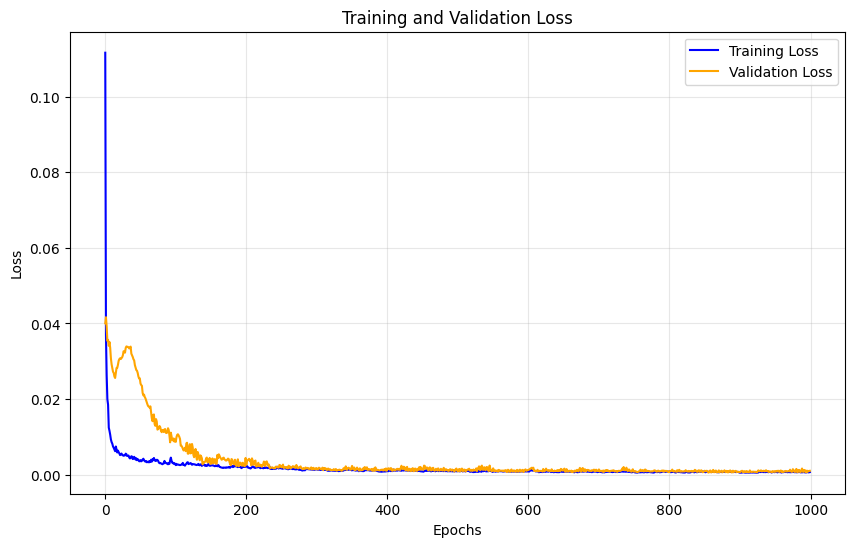

In [9]:
plot_loss(history)

# Prediction & Performance

In [10]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/CMAQ_Emulator/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

In [11]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.4/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
dataset_2013 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2013.csv')

ctrl_data = pd.concat([dataset_2013], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2013 = "/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2013"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2013, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['O3'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data = ctrl_data[:, :17*5]

_, X_emis_test, _, y_test = train_test_split(pred_emis_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test]) # 2가지 경계 조건에 따른 1년치 Nitrate
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2/2 [==============================] - 1s 413ms/step


In [12]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [13]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

In [14]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


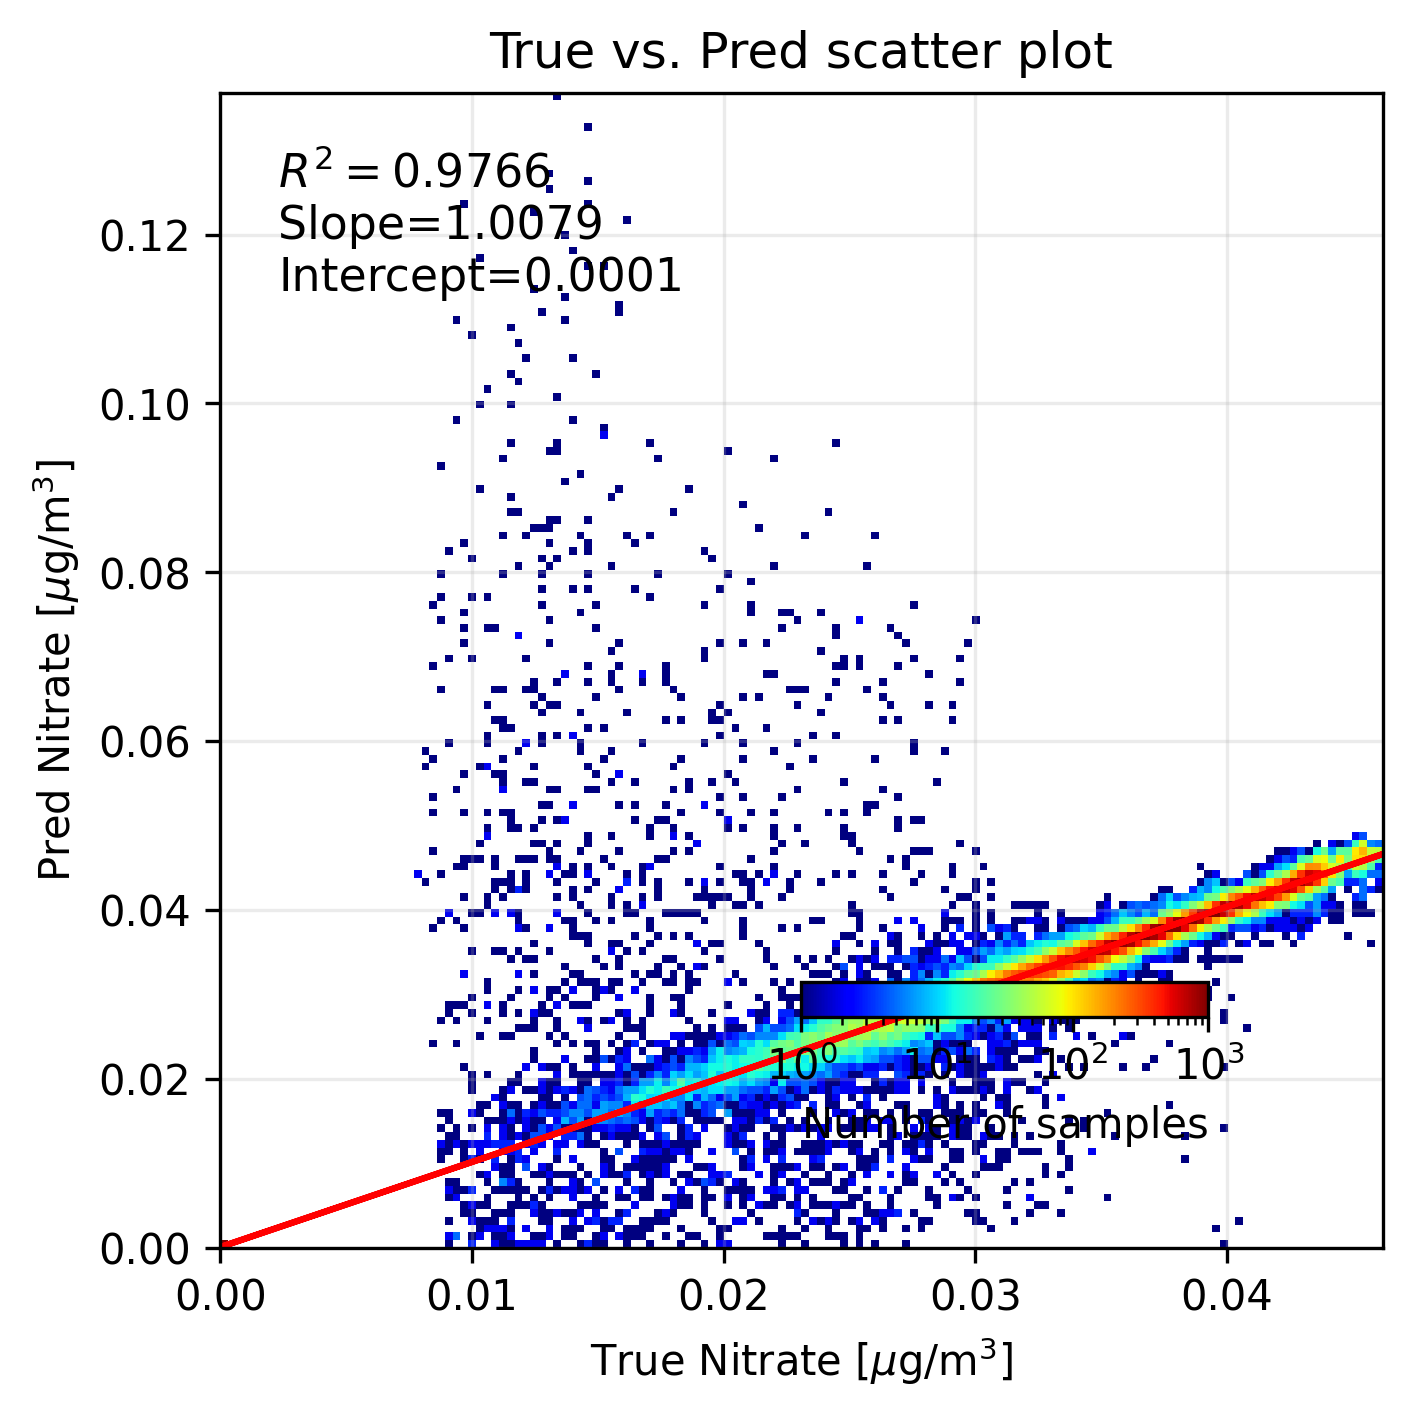

In [15]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

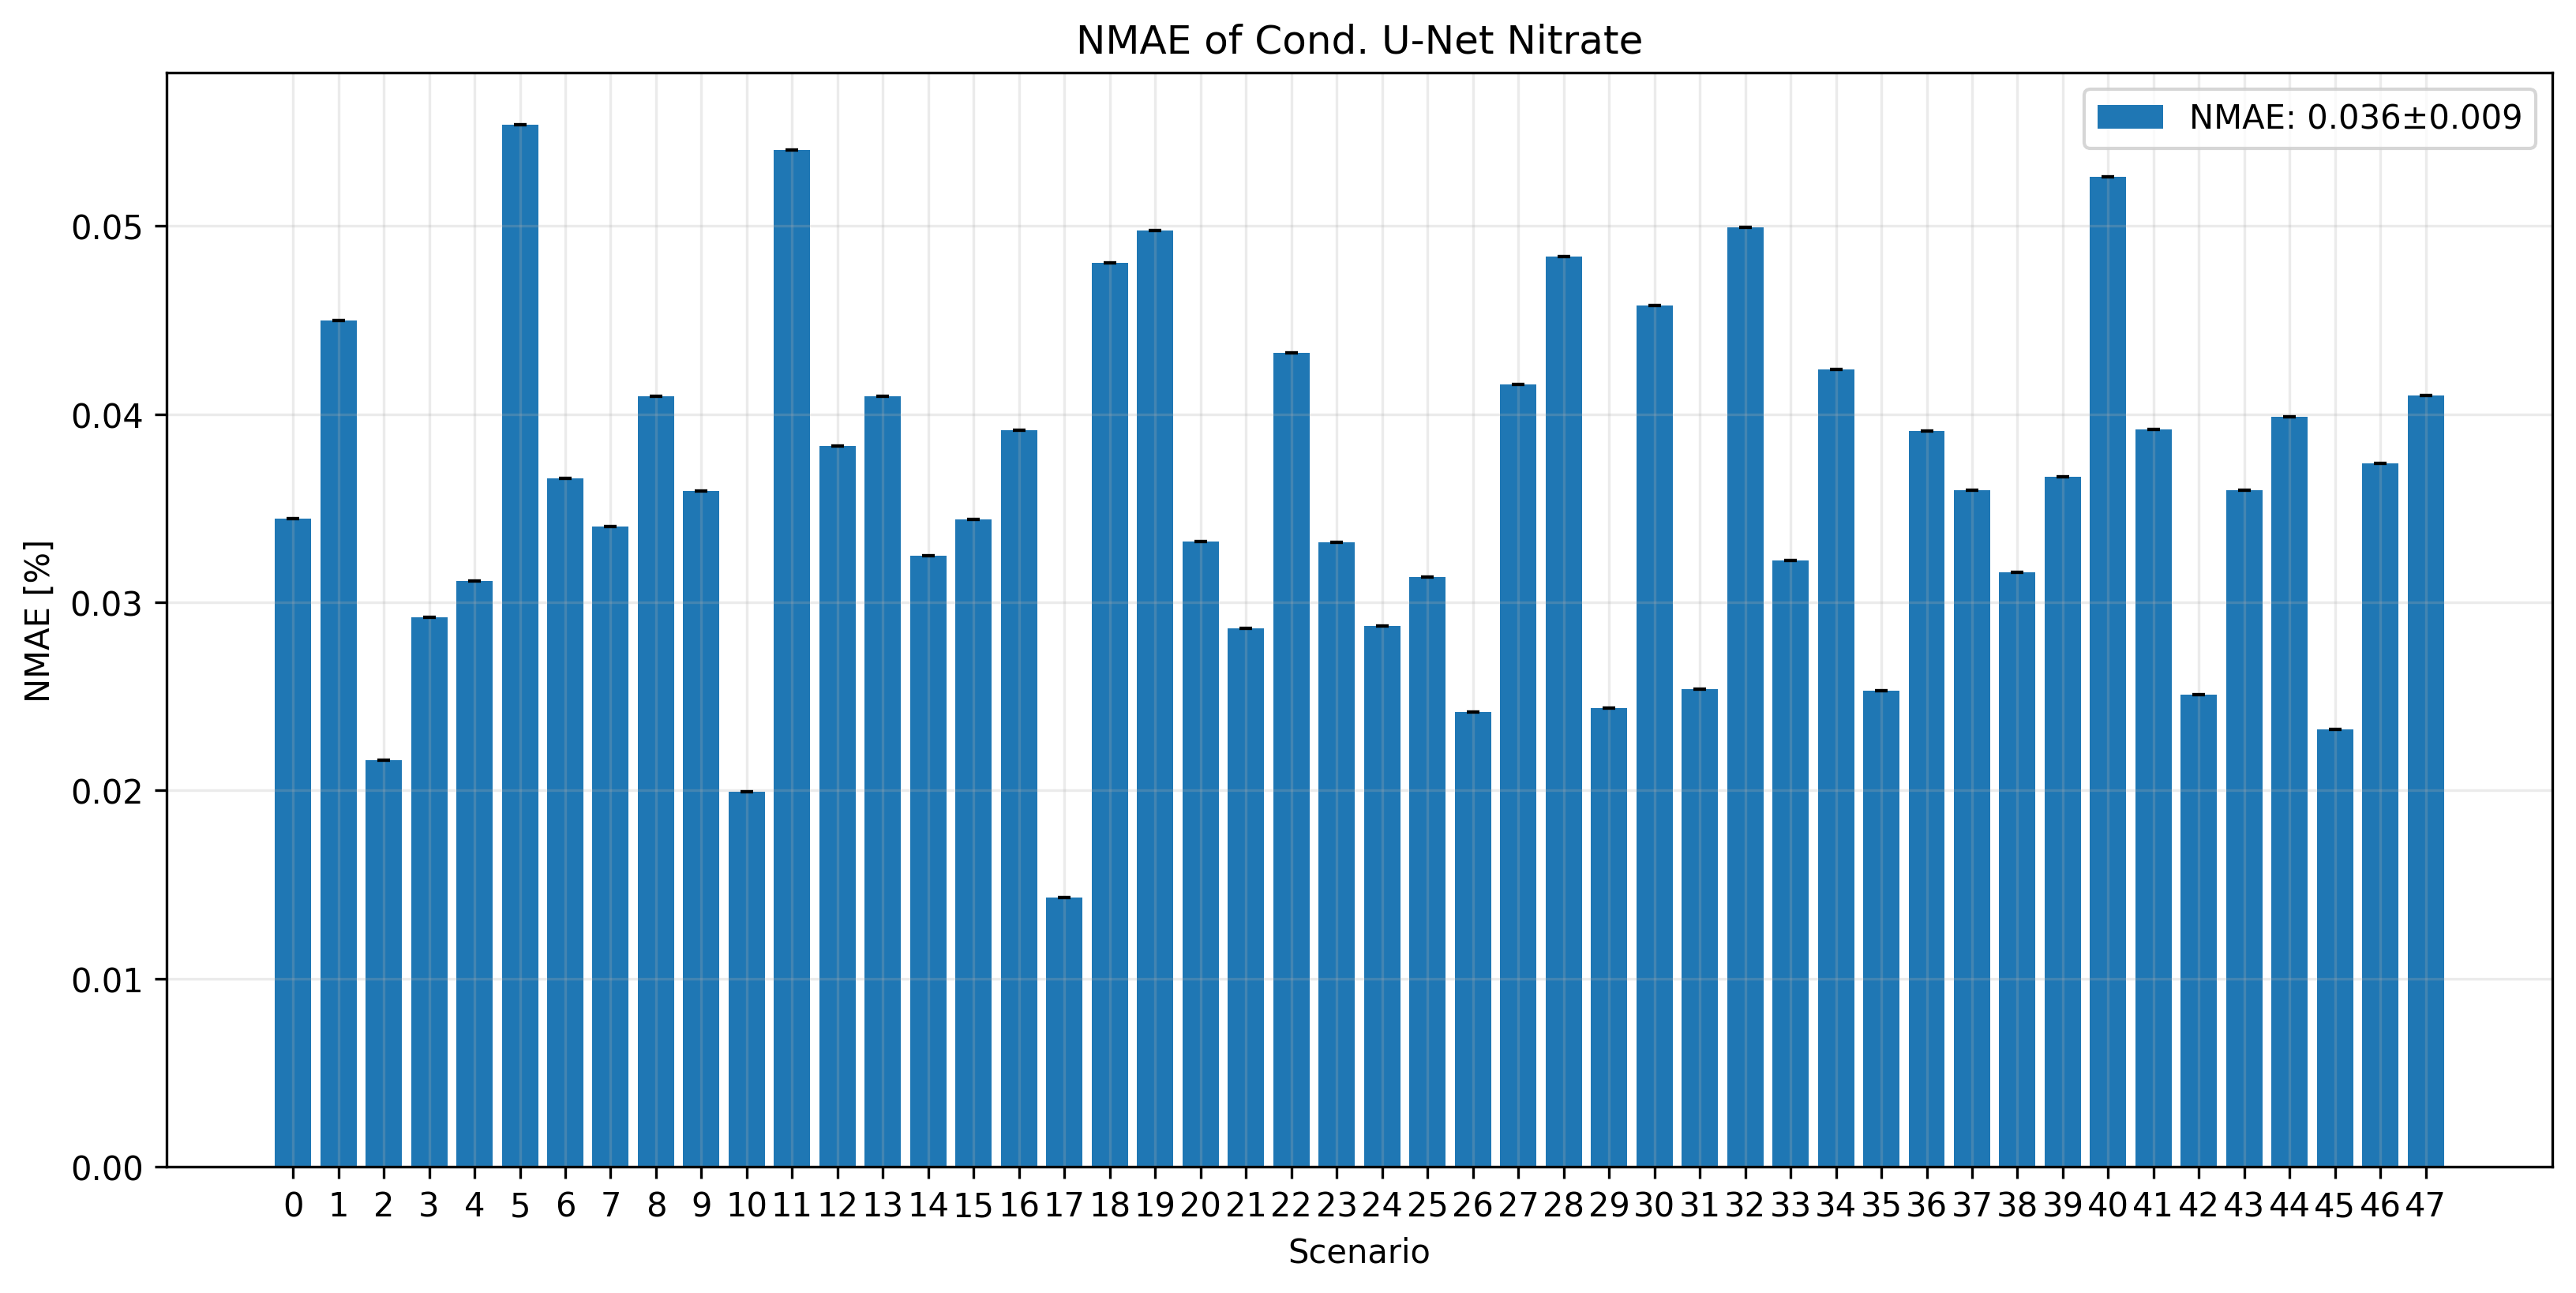

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()

In [17]:
# np.set_printoptions(threshold=sys.maxsize)
# print(true_conc_map_w_lines[17])

[0]


/tmp/ipykernel_2342184/815748241.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_2342184/815748241.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_2342184/815748241.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_2342184/815748241.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_2342184/815748241.py:67: UserWarning: set_ticklab

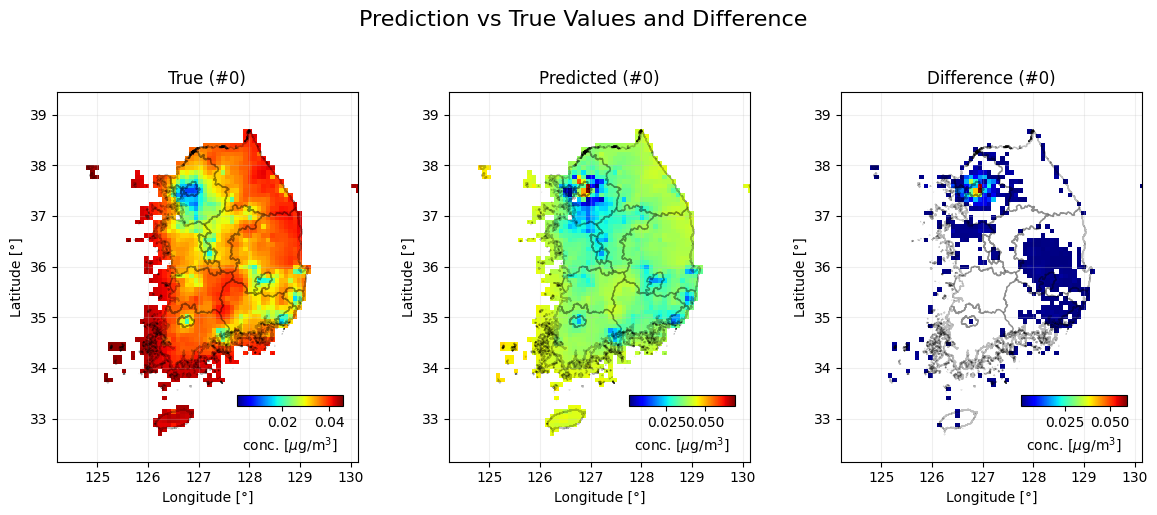

In [22]:
def plot_prediction_loss(y_true, y_pred, num_samples=1, indices=-1):
    if indices == -1 or indices < 0:
        indices = np.random.choice(len(y_true), num_samples, replace=False)
    else:
        index = indices
        indices = []
        indices.append(index) 
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines, indices=0)

In [19]:
true_conc_map_w_lines_re = true_conc_map_w_lines
pred_conc_map_w_lines_re = pred_conc_map_w_lines

true_conc_map_w_lines_re = np.delete(true_conc_map_w_lines, 17, axis=0)
pred_conc_map_w_lines_re = np.delete(pred_conc_map_w_lines, 17, axis=0)

print(true_conc_map_w_lines_re.shape)
print(pred_conc_map_w_lines_re.shape)

(47, 82, 67)
(47, 82, 67)


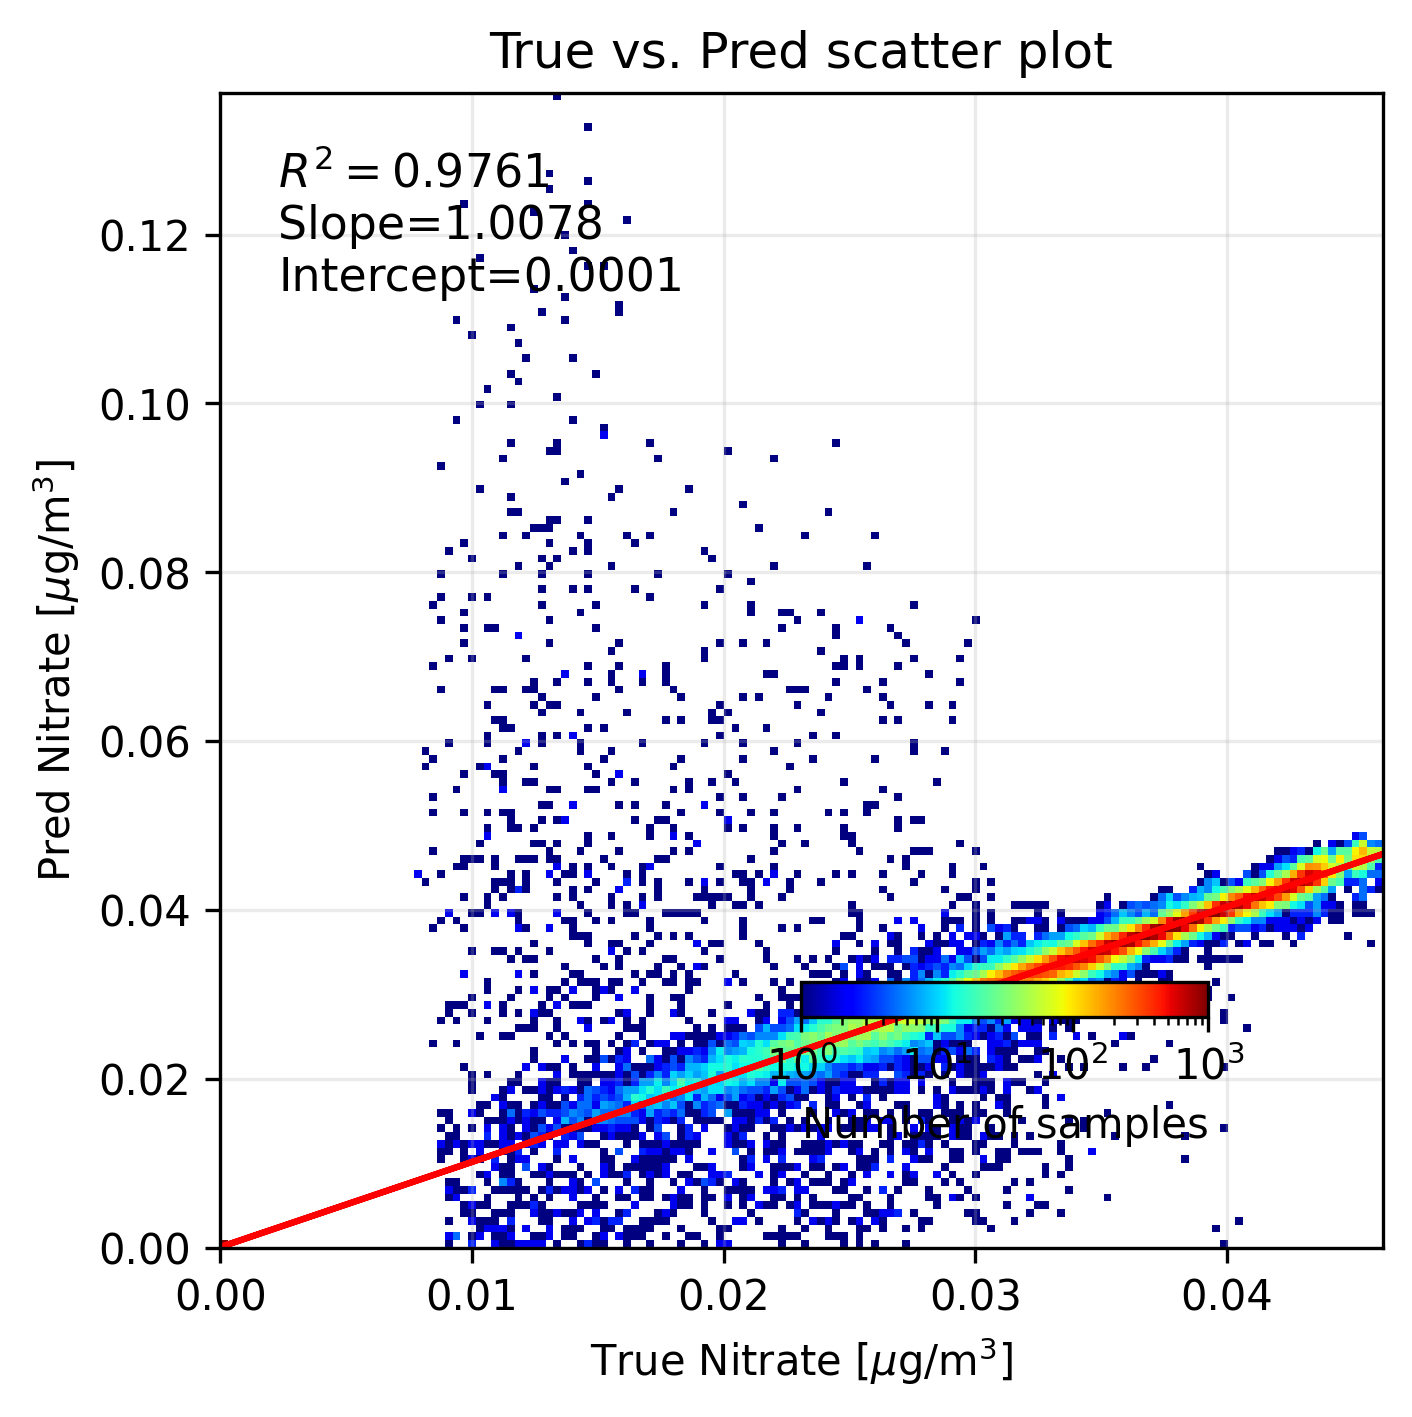

In [20]:
y_true_modi = true_conc_map_w_lines_re.reshape(-1)
y_pred_modi = pred_conc_map_w_lines_re.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

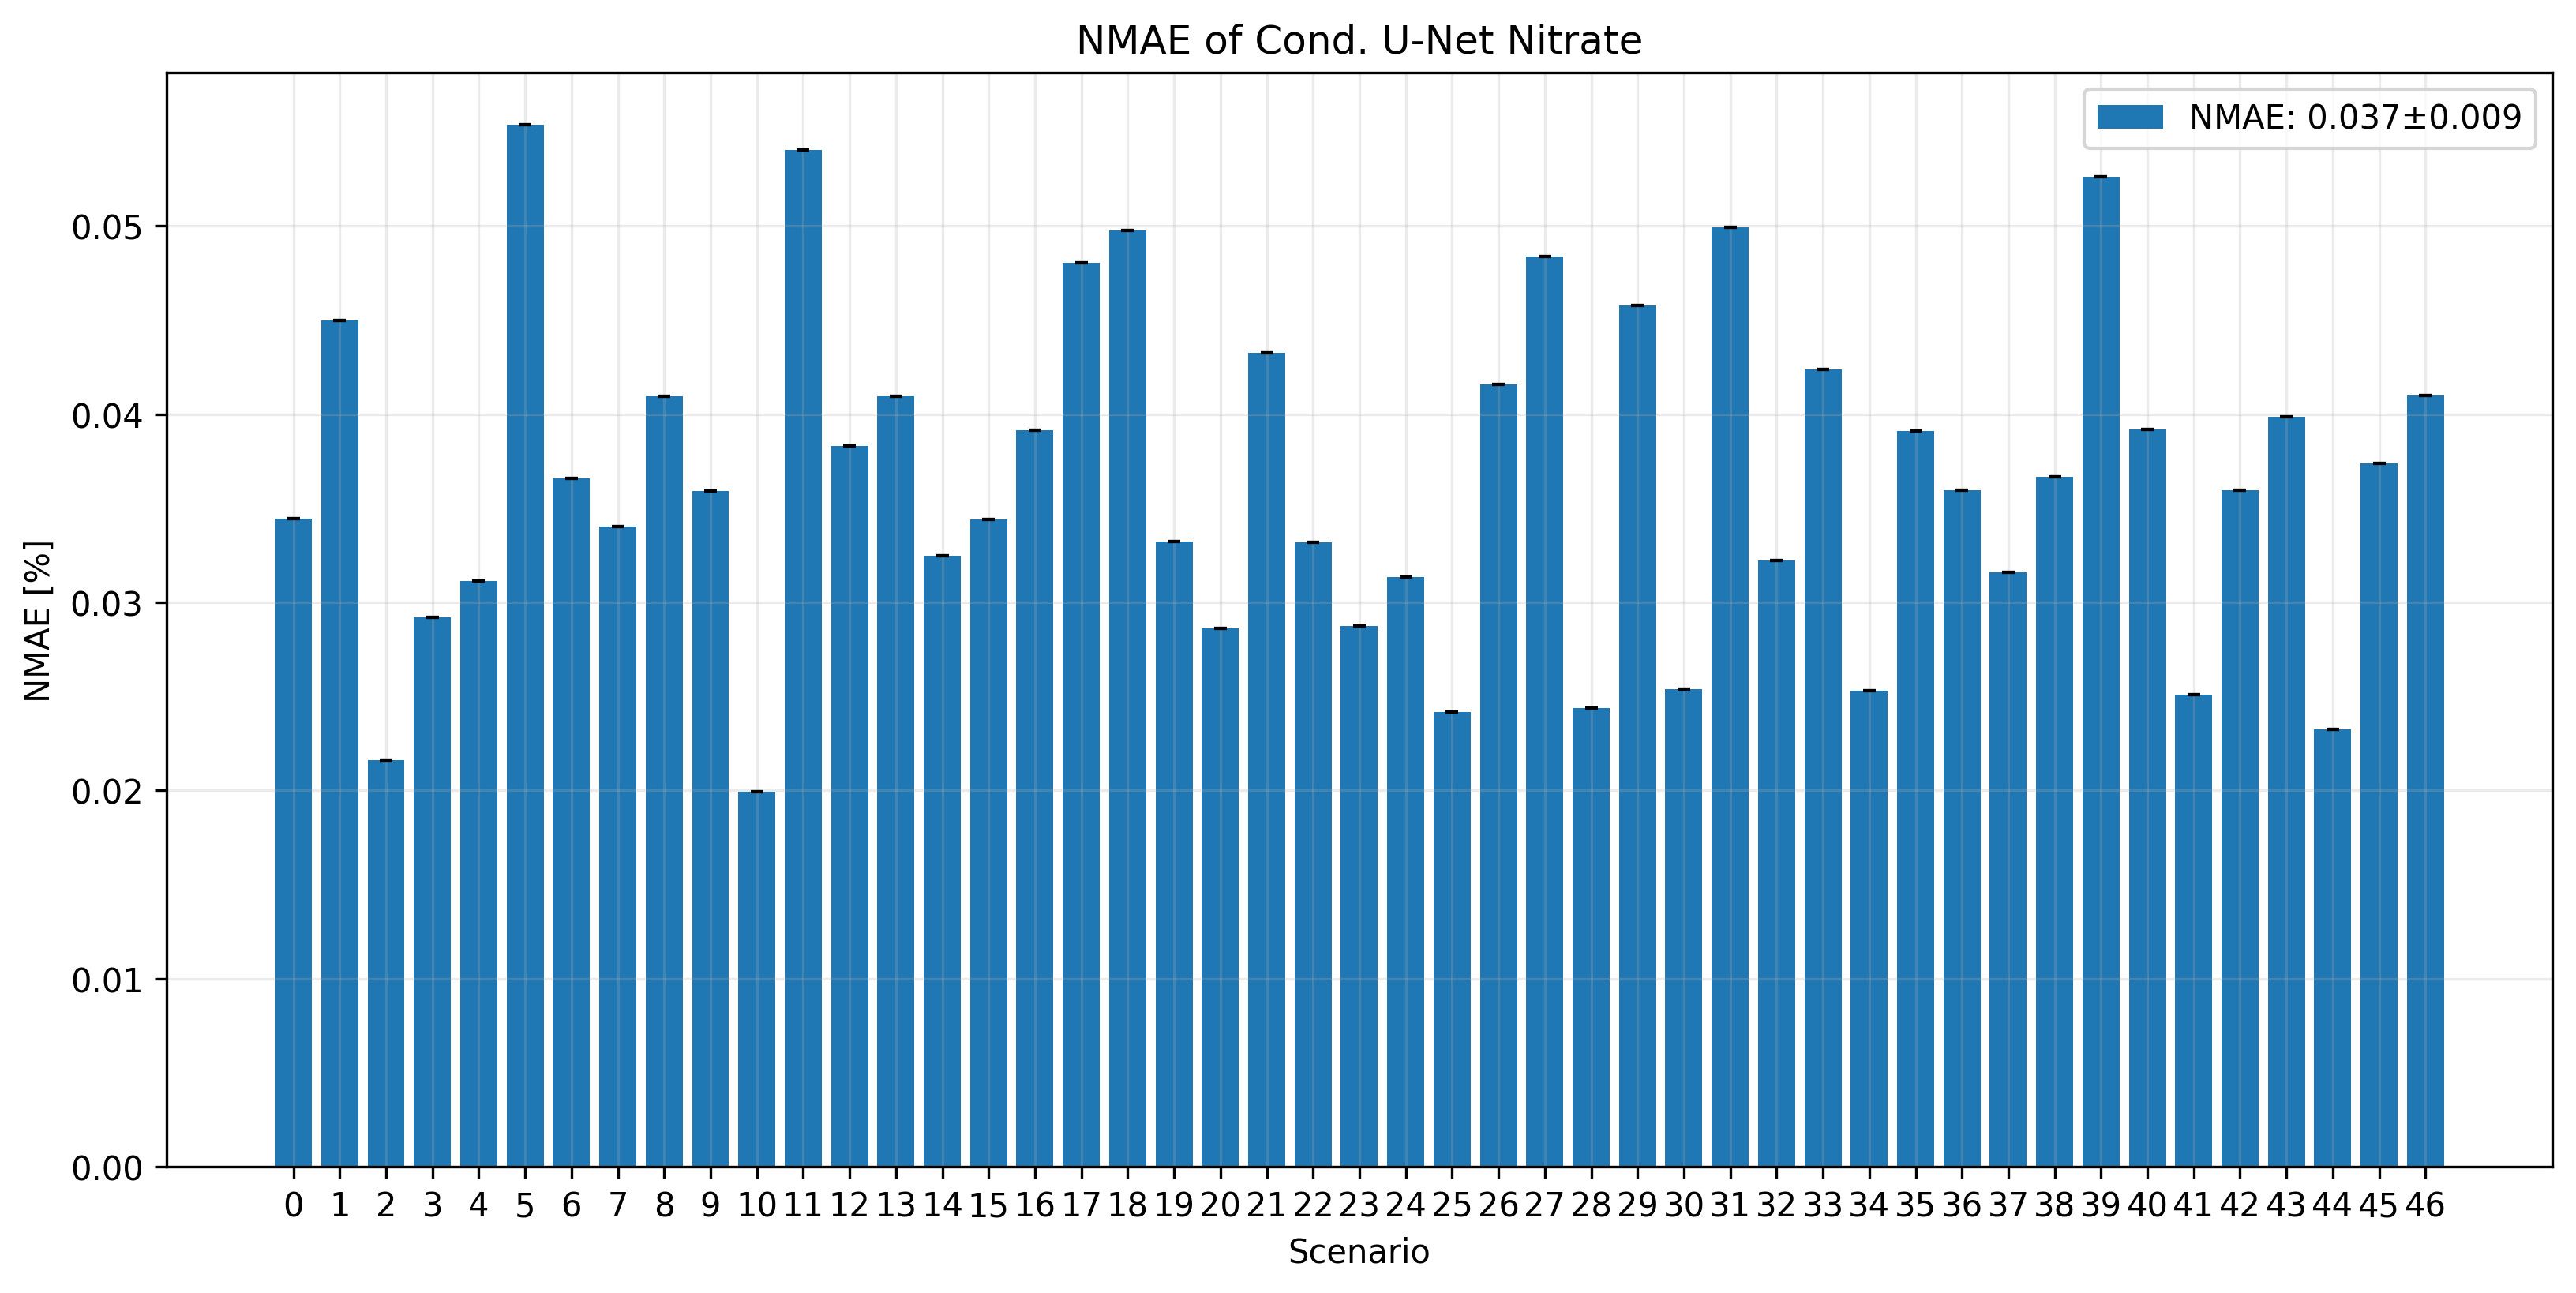

In [21]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines_re, pred_conc_map_w_lines_re)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]-1), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]-1), range(y_test.shape[0]-1))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()